# Extracting key information from documents

It is tough to read and retrieve informarion manually from documents. So, this project is an attempt to automate this process.

# 1)- Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pickle
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import seaborn as sns
sns.set(rc={'figure.figsize':(15,9)})
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [3]:
%reload_ext version_information
%version_information pandas,numpy, nltk, seaborn, matplotlib, re

Software versions
Python 3.7.4 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.8.0
OS Darwin 19.0.0 x86_64 i386 64bit
pandas 0.25.1
numpy 1.17.2
nltk 3.4.5
seaborn 0.9.0
matplotlib 3.1.1
re 2.2.1
Mon Dec 16 15:46:54 2019 CET

# 2)- Loading Dataset

from kaggle : https://www.kaggle.com/benhamner/nips-papers/data

In [4]:
data=pd.read_csv('papers.csv')
data.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 7 columns):
id            7241 non-null int64
year          7241 non-null int64
title         7241 non-null object
event_type    2422 non-null object
pdf_name      7241 non-null object
abstract      7241 non-null object
paper_text    7241 non-null object
dtypes: int64(2), object(5)
memory usage: 396.1+ KB


In [6]:
data.shape

(7241, 7)

In [7]:
# combining title and papertext to get a complete version of text. This will be our main text data
data['text']=data['title'] + data['paper_text']

In [8]:
data['text'][1]

'A Mean Field Theory of Layer IV of Visual Cortex and Its Application to Artificial Neural Networks683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISUAL CORTEX\nAND ITS APPLICATION TO ARTIFICIAL NEURAL NETWORKS*\nChristopher L. Scofield\nCenter for Neural Science and Physics Department\nBrown University\nProvidence, Rhode Island 02912\nand\nNestor, Inc., 1 Richmond Square, Providence, Rhode Island,\n02906.\nABSTRACT\nA single cell theory for the development of selectivity and\nocular dominance in visual cortex has been presented previously\nby Bienenstock, Cooper and Munrol. This has been extended to a\nnetwork applicable to layer IV of visual cortex 2 . In this paper\nwe present a mean field approximation that captures in a fairly\ntransparent manner the qualitative, and many of the\nquantitative, results of the network theory. Finally, we consider\nthe application of this theory to artificial neural networks and\nshow that a significant reduction in architectural complexity is\npossible.\

In [9]:
# we shall create a smaller dataset with our features of interest

dataset= data[['id','year','text']]

In [10]:
dataset.shape

(7241, 3)

In [11]:
dataset.head()

,id,year,text
0,1,1987,Self-Organization of Associative Database and ...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...
2,100,1988,Storing Covariance by the Associative Long-Ter...
3,1000,1994,Bayesian Query Construction for Neural Network...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an..."


In [12]:
dataset.tail()

,id,year,text
7236,994,1994,Single Transistor Learning SynapsesSingle Tran...
7237,996,1994,"Bias, Variance and the Combination of Least Sq..."
7238,997,1994,A Real Time Clustering CMOS Neural EngineA Rea...
7239,998,1994,Learning direction in global motion: two class...
7240,999,1994,Correlation and Interpolation Networks for Rea...


# 3)- data exploration

### 3.1)-Number of published papers per year

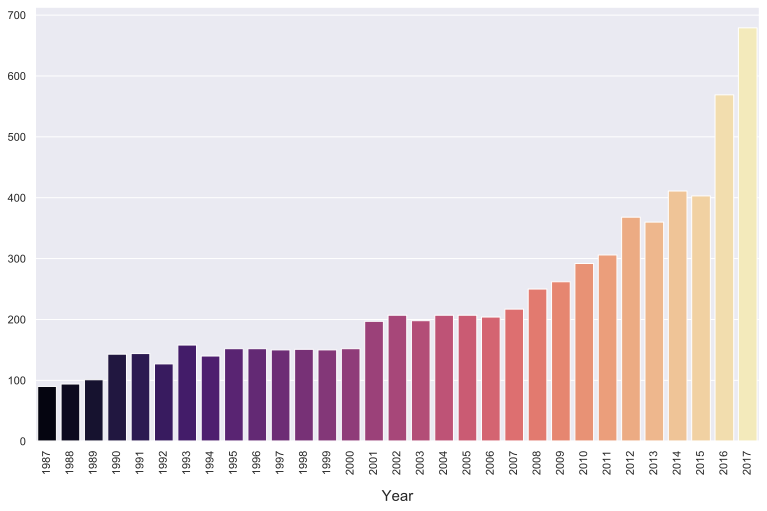

In [13]:
groups = dataset.groupby('year')
counts = groups.size()

plt.figure(figsize = (13, 8))
ax = sns.barplot(counts.index, counts.values, palette=("magma"))
ax.set_xlabel("Year",fontsize = 15, labelpad = 15)
plt.xticks(rotation = 90)
plt.show()

This graph shows how amount of papers are being accumulted over the years. Recent years have seen an increase in publication and it is a nice trend to consider for further analysis.

### 3.2)- Word count for text

In [14]:
#Fetch wordcount for each text document
dataset['w_count'] = dataset['text'].apply(lambda x: len(str(x).split(" ")))
dataset[['text','w_count']].head(10)

,text,w_count
0,Self-Organization of Associative Database and ...,3321
1,A Mean Field Theory of Layer IV of Visual Cort...,2249
2,Storing Covariance by the Associative Long-Ter...,2741
3,Bayesian Query Construction for Neural Network...,2929
4,"Neural Network Ensembles, Cross Validation, an...",3016
5,Using a neural net to instantiate a deformable...,3343
6,Plasticity-Mediated Competitive LearningPlasti...,1661
7,ICEG Morphology Classification using an Analog...,2478
8,Real-Time Control of a Tokamak Plasma Using Ne...,2405
9,Pulsestream Synapses with Non-Volatile Analogu...,4289


In [15]:
dataset[['text','w_count']].tail(10)

,text,w_count
7231,Analog Implementation of Shunting Neural Netwo...,1754
7232,Learning with Product UnitsComparing the predi...,4564
7233,Stochastic Dynamics of Three-State Neural Netw...,1678
7234,Grouping Components of Three-Dimensional Movin...,1224
7235,Visual Speech Recognition with Stochastic Netw...,2396
7236,Single Transistor Learning SynapsesSingle Tran...,2642
7237,"Bias, Variance and the Combination of Least Sq...",3619
7238,A Real Time Clustering CMOS Neural EngineA Rea...,2022
7239,Learning direction in global motion: two class...,2827
7240,Correlation and Interpolation Networks for Rea...,3082


In [16]:
##Descriptive statistics of word counts

dataset.w_count.describe()

count     7241.000000
mean      4265.871427
std       1237.636598
min          7.000000
25%       3218.000000
50%       4480.000000
75%       5201.000000
max      11526.000000
Name: w_count, dtype: float64

**Some insight from above:**

- Average word count in our text document is 4265 words per document. The word count ranges from a minimum of 7 word to maximum of 11526 words. This is useful information in a sense that it indicates size of dataset and also variation in word count across the rows
    
    
    

### 3.3)- Most common and uncommon words

A peek into the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. A comparison of the most common words and the default English stop words will give us a list of words that need to be added to a custom stop word list.

In [17]:
#Identify top 20 most common/frequently occuring words
common = pd.Series(' '.join(dataset['text']).split()).value_counts()[:20]
common

the     1742074
of       994278
and      739119
?        643829
a        585594
to       565931
is       496200
in       473232
for      352845
that     291218
=        282147
,        226448
we       226390
with     224729
The      208146
on       193863
.        190765
by       185167
are      182559
as       181199
dtype: int64

Most of them are stop words and if we remove them then our data will be lighter. Also they are not contributing towards meaning of document so, removing them won't take away any useful information

In [18]:
#Identify top 20 uncommon words
uncommon=pd.Series(' '.join(dataset['text']).split()).value_counts()[-20:]
uncommon

TIOdyessy                1
dexes                    1
x](l-                    1
//m                     1
l-2.05,                  1
exp(?B(Z)                1
:;Vms')]}                1
Wd?1                     1
3407-3416.               1
,'.?                     1
unit                    1
(devices                 1
error?is                 1
best3                    1
(A)]i,j                  1
Wk+l.ei                  1
?Wisdom                  1
instance-neighborhood    1
3067.30                  1
|.2                      1
dtype: int64

Some of these words are non-sense strings and we can drop them as well and there won't be any change in meaning of document.

# 4)- Text Preprocessing

- clean-up
- shrink vocab
- reduce sparsity

### 4.1)- Text cleaning

This is due to irrelevant words as we observed above. These additional and non-useful words contribute to noise in data and also data size is bigger.

So, we need to 

a)- Remove noise in text data(includes removal of stopwords, punctuation, tags,URLs, etc.) <br>
b)- Normalize text data(includes lemmatization or stemming)

In [19]:
# we shall use lemmatization for word normalization 

from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

In [20]:
# for noise removal

import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hassansherwani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
# for cleaning stopwords, we can use nltk default stopword list. Or we can add also more to this list

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [22]:
# in previous excercise of spam/ham, I have worked over step by step cleaning process. Here, I'd do all in one 
#swift step for all documents in dataset. By the way, these documents collected are called "Corpus"

corpus = []
for i in range(0, 7241): # size of total documents within our dataset
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['text'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

**For comparison between cleaned and uncleaned data**

In [23]:
# for original text data

unclean=dataset['text']

In [24]:
unclean[20]

'Connectionist Speaker Normalization with Generalized Resource Allocating NetworksConnectionist Speaker Normalization\nwith Generalized\nResource Allocating Networks\n\nCesare Furlanello\nIstituto per La Ricerca\nScientifica e Tecnologica\nPovo (Trento), Italy\nfurlan?lirst. it\n\nDiego Giuliani\nIstituto per La Ricerca\nScientifica e Tecnologica\nPovo (Trento), Italy\ngiuliani?lirst.it\n\nEdmondo Trentin\nIstituto per La Ricerca\nScientifica e Tecnologica\nPovo (Trento), Italy\ntrentin?lirst.it\n\nAbstract\nThe paper presents a rapid speaker-normalization technique based\non neural network spectral mapping. The neural network is used\nas a front-end of a continuous speech recognition system (speakerdependent, HMM-based) to normalize the input acoustic data from\na new speaker. The spectral difference between speakers can be\nreduced using a limited amount of new acoustic data (40 phonetically rich sentences). Recognition error of phone units from the\nacoustic-phonetic continuous spee

In [25]:
corpus[20]

'connectionist speaker normalization generalized resource allocating networksconnectionist speaker normalization generalized resource allocating network cesare furlanello istituto per la ricerca scientifica e tecnologica povo trento italy furlan lirst diego giuliani istituto per la ricerca scientifica e tecnologica povo trento italy giuliani lirst edmondo trentin istituto per la ricerca scientifica e tecnologica povo trento italy trentin lirst abstract paper present rapid speaker normalization technique based neural network spectral mapping neural network used front end continuous speech recognition system speakerdependent hmm based normalize input acoustic data speaker spectral difference speaker reduced limited amount acoustic data phonetically rich sentence recognition error phone unit acoustic phonetic continuous speech corpus apasci decreased adaptability ratio used local basis network elliptical gaussian kernel recursive allocation unit line optimization parameter gran model appl

### 4.2)- Word Cloud Visualization

In [26]:
dataset['corpus']= corpus

In [27]:
dataset.head()

,id,year,text,w_count,corpus
0,1,1987,Self-Organization of Associative Database and ...,3321,self organization associative database applica...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,2249,mean field theory layer visual cortex applicat...
2,100,1988,Storing Covariance by the Associative Long-Ter...,2741,storing covariance associative long term poten...
3,1000,1994,Bayesian Query Construction for Neural Network...,2929,bayesian query construction neural network mod...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",3016,neural network ensemble cross validation activ...


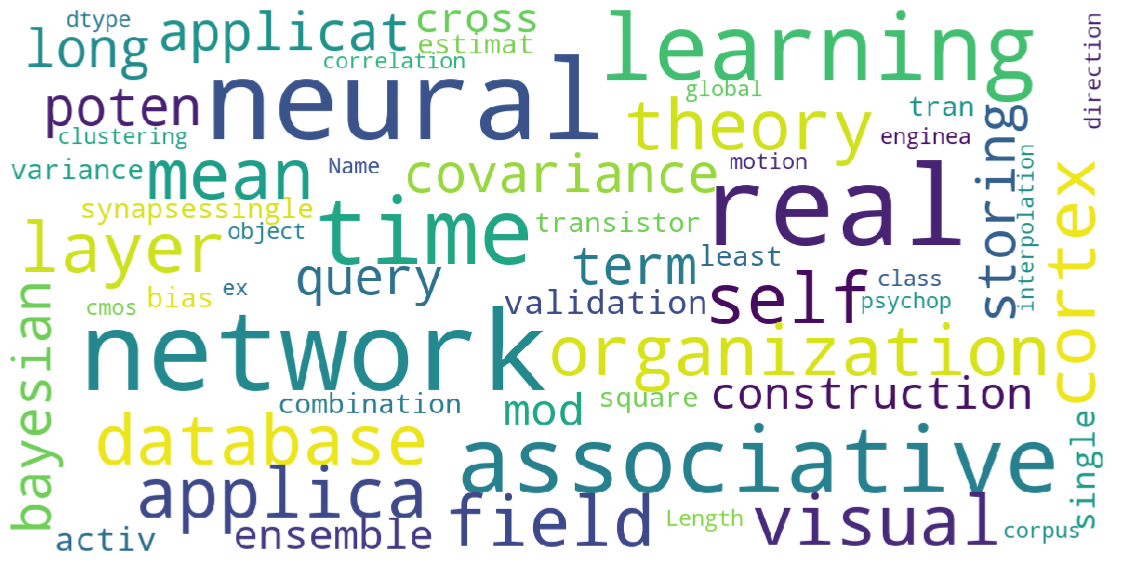

In [28]:
from wordcloud import WordCloud, STOPWORDS
stopwords=set(STOPWORDS)

def Mywordcloud (data, title=None):
    wordcloud=WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words= 100 ,
    max_font_size=40 ,
    scale=3,
    random_state=1
    ).generate(str(data))
    
    fig=plt.figure(1 , figsize(20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    
    plt.imshow(wordcloud)
    plt.show()
Mywordcloud(dataset['corpus'].dropna())

# 5)- Vectorization

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import re

### 5.1)- Count Vectorizer

In [30]:
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus) # we do fit and transform in one instant

- **cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))**

- max_df — When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). This is to ensure that we only have words relevant to the context and not commonly used words.

- max_features — determines the number of columns in the matrix.

- n-gram range — we would want to look at a list of single words, two words (bi-grams) and three words (tri-gram) combinations.

In [31]:
X.shape

(7241, 10000)

In [32]:
# An encoded vector is returned with a length of the entire vocabulary.

list(cv.vocabulary_.keys())[:10]

['self',
 'organization',
 'associative',
 'database',
 'application',
 'japan',
 'efficient',
 'organizing',
 'proposed',
 'together']

### 5.2)- Visualization 


using uni-gram, bi-gram, and tri-gram

#### 5.2.1)-Uni-gram

[Text(0, 0, 'model'),
 Text(0, 0, 'algorithm'),
 Text(0, 0, 'learning'),
 Text(0, 0, 'function'),
 Text(0, 0, 'data'),
 Text(0, 0, 'set'),
 Text(0, 0, 'network'),
 Text(0, 0, 'method'),
 Text(0, 0, 'problem'),
 Text(0, 0, 'time'),
 Text(0, 0, 'distribution'),
 Text(0, 0, 'number'),
 Text(0, 0, 'figure'),
 Text(0, 0, 'matrix'),
 Text(0, 0, 'value'),
 Text(0, 0, 'parameter'),
 Text(0, 0, 'feature'),
 Text(0, 0, 'image'),
 Text(0, 0, 'training'),
 Text(0, 0, 'state')]

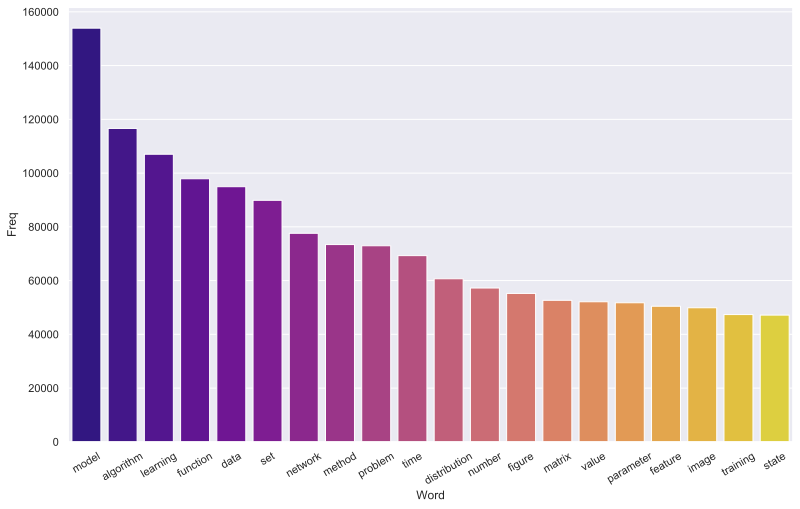

In [33]:
#Most frequently occuring uni-gram words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Bar plot of most frequent uni-grams
sns.set(rc={'figure.figsize':(13,8)})
g=sns.barplot(x="Word", y="Freq",palette=("plasma"), data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

#### 5.2.2)-Bi-gram

                     Bi-gram   Freq
0                      et al  20583
1             neural network  20322
2           machine learning  15781
3                   data set   9594
4     information processing   9590
5         neural information   9101
6          processing system   9045
7               training set   7647
8         learning algorithm   7232
9                lower bound   7119
10  international conference   6900
11            advance neural   6816
12               figure show   5958
13             training data   5870
14             loss function   5744
15                   log log   5692
16      optimization problem   5590
17               upper bound   5554
18                data point   5444
19    reinforcement learning   5227


[Text(0, 0, 'et al'),
 Text(0, 0, 'neural network'),
 Text(0, 0, 'machine learning'),
 Text(0, 0, 'data set'),
 Text(0, 0, 'information processing'),
 Text(0, 0, 'neural information'),
 Text(0, 0, 'processing system'),
 Text(0, 0, 'training set'),
 Text(0, 0, 'learning algorithm'),
 Text(0, 0, 'lower bound'),
 Text(0, 0, 'international conference'),
 Text(0, 0, 'advance neural'),
 Text(0, 0, 'figure show'),
 Text(0, 0, 'training data'),
 Text(0, 0, 'loss function'),
 Text(0, 0, 'log log'),
 Text(0, 0, 'optimization problem'),
 Text(0, 0, 'upper bound'),
 Text(0, 0, 'data point'),
 Text(0, 0, 'reinforcement learning')]

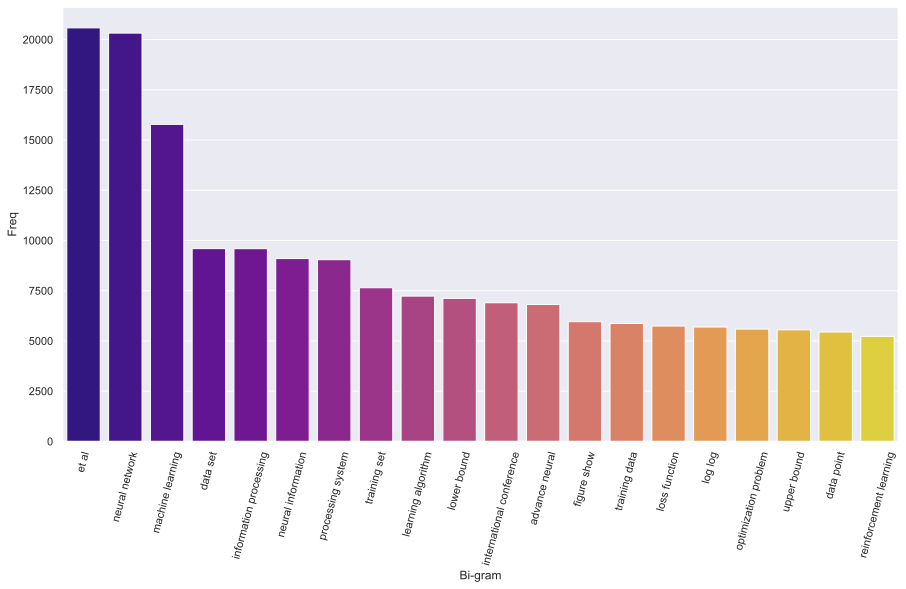

In [34]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# for bi-gram

top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams

sns.set(rc={'figure.figsize':(15,8)})
h=sns.barplot(x="Bi-gram", y="Freq",palette=("plasma"), data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=75)

#### 5.2.3)-Tri-gram

                            Tri-gram  Freq
0      neural information processing  8999
1      information processing system  8851
2         advance neural information  6687
3               arxiv preprint arxiv  3621
4        conference machine learning  3544
5   international conference machine  3368
6          machine learning research  3220
7           journal machine learning  3077
8             processing system page  2644
9              processing system nip  2441
10            support vector machine  2377
11       th international conference  1615
12       department computer science  1535
13                       log log log  1519
14          recurrent neural network  1515
15               hidden markov model  1512
16       proceeding th international  1464
17          semi supervised learning  1457
18     conference neural information  1452
19       stochastic gradient descent  1387


[Text(0, 0, 'neural information processing'),
 Text(0, 0, 'information processing system'),
 Text(0, 0, 'advance neural information'),
 Text(0, 0, 'arxiv preprint arxiv'),
 Text(0, 0, 'conference machine learning'),
 Text(0, 0, 'international conference machine'),
 Text(0, 0, 'machine learning research'),
 Text(0, 0, 'journal machine learning'),
 Text(0, 0, 'processing system page'),
 Text(0, 0, 'processing system nip'),
 Text(0, 0, 'support vector machine'),
 Text(0, 0, 'th international conference'),
 Text(0, 0, 'department computer science'),
 Text(0, 0, 'log log log'),
 Text(0, 0, 'recurrent neural network'),
 Text(0, 0, 'hidden markov model'),
 Text(0, 0, 'proceeding th international'),
 Text(0, 0, 'semi supervised learning'),
 Text(0, 0, 'conference neural information'),
 Text(0, 0, 'stochastic gradient descent')]

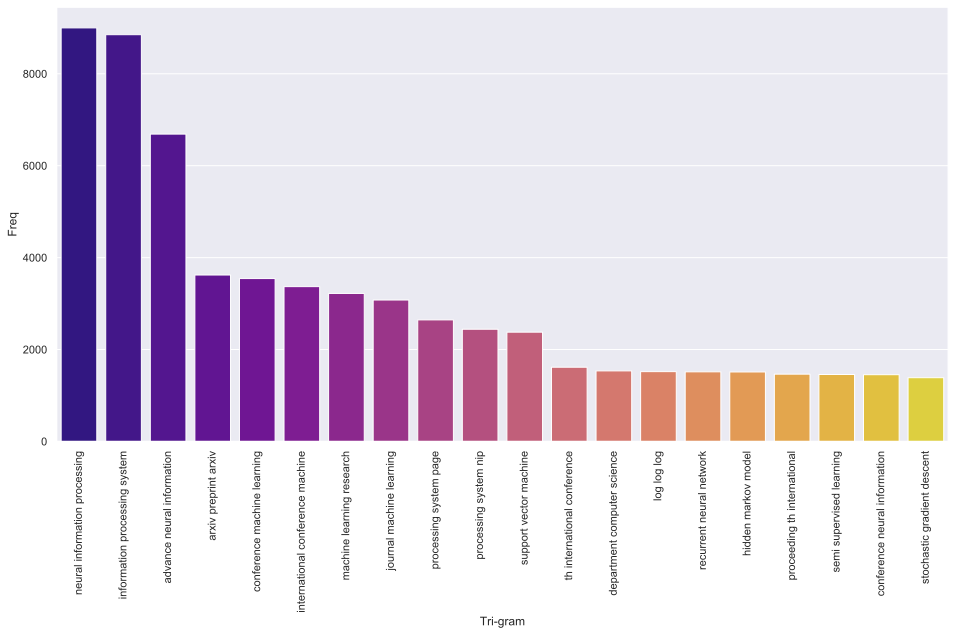

In [35]:
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

# for tri-gram
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

#Barplot of most freq Tri-grams
sns.set(rc={'figure.figsize':(16,8)})
j=sns.barplot(x="Tri-gram", y="Freq",palette=("plasma"), data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=90)

# 6)- TF-IDF

Converting corpus to a matrix of integer

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()

In [37]:
# fetch document for which keywords needs to be extracted
doc=corpus[20]

In [38]:
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [39]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
connectionist speaker normalization generalized resource allocating networksconnectionist speaker normalization generalized resource allocating network cesare furlanello istituto per la ricerca scientifica e tecnologica povo trento italy furlan lirst diego giuliani istituto per la ricerca scientifica e tecnologica povo trento italy giuliani lirst edmondo trentin istituto per la ricerca scientifica e tecnologica povo trento italy trentin lirst abstract paper present rapid speaker normalization technique based neural network spectral mapping neural network used front end continuous speech recognition system speakerdependent hmm based normalize input acoustic data speaker spectral difference speaker reduced limited amount acoustic data phonetically rich sentence recognition error phone unit acoustic phonetic continuous speech corpus apasci decreased adaptability ratio used local basis network elliptical gaussian kernel recursive allocation unit line optimization parameter gran 

So while researchers or scientists do invest so much for reading a document, it is wise to create an automated method which could identify keywords of that document like most of scientific journals do.